Install transformers.

In [ ]:
# install from repository otherwise we would get an error.
! pip install -U git+https://github.com/huggingface/transformers.git
! pip install -U git+https://github.com/huggingface/accelerate.git

# Read the Data

In [ ]:
!wget https://raw.githubusercontent.com/PacktPublishing/Python-Natural-Language-Processing-Cookbook/master/Chapter04/bbc-text.csv

In [4]:
import csv

def read_csv(csv_file):
  with open(csv_file, 'r', encoding='utf-8') as f:
    reader = csv.reader(f, delimiter=',', quotechar='"')
    data_read = [row for row in reader]
    return data_read

def get_data(filename):
  data = read_csv(filename)
  data_dict = {}
  for row in data[1:]:
    category = row[0]
    text = row[1]
    if (category not in data_dict.keys()):
      data_dict[category] = []
    data_dict[category].append(text)
  return data_dict

dataset = get_data("/content/bbc-text.csv")

<Axes: xlabel='category', ylabel='count'>

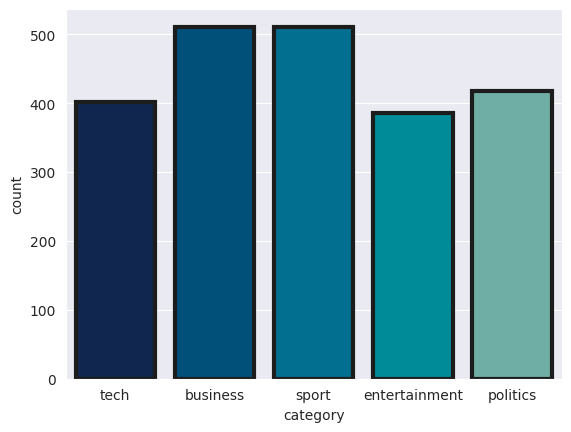

In [5]:
import pandas as pd

category_count = {key: len(dataset[key]) for key in dataset.keys()}
category_count_df = pd.DataFrame(category_count.items(), columns=["category", "count"])

import seaborn as sns
import matplotlib.pyplot as plt
sns.set({"axes.facecolor":"#F2EAC5", "figure.facecolor":"#F2EAC5"})
palette = ["#11264e","#00507A","#026e90",
           "#008b99","#6faea4","#fcdcb0","#FEE08B","#faa96e","#f36b3b","#ef3f28","#CC0028"]
sns.barplot(data=category_count_df, x="category", y="count",palette=palette,
            edgecolor="#1c1c1c", linewidth=3, saturation=1,)

In [6]:
import math
def split_test_train(data, train_percent):
  train_test_border = \
  math.ceil(train_percent*len(data))
  train_data = data[0:train_test_border]
  test_data = data[train_test_border:]
  return (train_data, test_data)

business_data = dataset["business"]
sports_data = dataset["sport"]

business_label = ["business"] * len(business_data)
sport_label = ["sport"] * len(sports_data)

business_string = " ".join(business_data)
sports_string = " ".join(sports_data)

(business_train_data, business_test_data) = split_test_train(business_data, 0.8)
(sports_train_data, sports_test_data) = split_test_train(sports_data, 0.8)

train_data = business_train_data + sports_train_data
train_labels = [1] * len(business_train_data) + [0] * len(sports_train_data)

test_data = business_test_data + sports_test_data
test_labels = [1] * len(business_test_data) + [0] * len(sports_test_data)

In [7]:
import tensorflow as tf
import tensorflow_datasets as tfds

train_ds = tf.data.Dataset.from_tensor_slices((train_data, train_labels))
test_ds = tf.data.Dataset.from_tensor_slices((test_data, test_labels))

In [8]:
from transformers import RobertaTokenizer
roberta_tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

max_length = 100
batch_size = 64

def tokenize(review):
  return roberta_tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=max_length,
      padding=True,
      truncation=True,
      return_attention_mask=True
  )

def to_dict(input_ids, attention_masks, label):
  return {
      "input_ids": input_ids,
      "attention_mask": attention_masks,
           }, label

def encode(ds):
  input_ids_list = []
  attention_mask_list = []
  label_list = []

  for review, label in tfds.as_numpy(ds):
    input = tokenize(review.decode())

    input_ids_list.append(input["input_ids"])
    attention_mask_list.append(input["attention_mask"])
    label_list.append(label)

  return tf.data.Dataset.from_tensor_slices((input_ids_list,
                                             attention_mask_list,
                                             label_list)).map(to_dict)

ds_train_encoded = encode(train_ds).shuffle(10000).batch(batch_size)
ds_test_encoded = encode(test_ds).batch(batch_size)

In [10]:
learning_rate = 7e-5
number_of_epochs = 8
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import f1_score
import os

class myCallback(Callback):
  def on_train_begin(self, logs={}):
    self.count = 1

  def on_epoch_end(self, batch, logs={}):
    if not os.path.exists("save/model" + str(self.count)):
      os.makedirs("save/model" + str(self.count))
    self.model.save_pretrained("save/model" + str(self.count))

    y_pred = self.model.predict(ds_test_encoded)["logits"]
    y_pred = tf.nn.softmax(tf.convert_to_tensor(y_pred))
    y_pred = tf.math.argmax(y_pred, axis=1)
    f1_s = f1_score(test_labels, y_pred)
    print('\n f1 score is :', f1_s)
    self.count += 1

metrics = myCallback()

from transformers import TFRobertaForSequenceClassification
# model initialization
model = TFRobertaForSequenceClassification.from_pretrained("roberta-base")
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, epsilon=1e-08)

# we do not have one-hot vectors, we can use sparce categorical cross entropy and accuracy
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

In [11]:
%load_ext tensorboard

# Clear any logs from previous runs
!rm -rf ./logs/

log_dir = "logs/fit/"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [12]:
model.fit(ds_train_encoded, epochs=number_of_epochs,
          validation_data=ds_test_encoded, callbacks=[metrics])#, tensorboard_callback])

Epoch 1/8
4/4 [==============================] - 5s 292ms/step

 f1 score is : 0.9577464788732395
13/13 [==============================] - 85s 2s/step - loss: 0.3438 - accuracy: 0.8543 - val_loss: 0.2036 - val_accuracy: 0.9559
Epoch 2/8
4/4 [==============================] - 1s 295ms/step

 f1 score is : 0.9902912621359222
13/13 [==============================] - 22s 2s/step - loss: 0.0698 - accuracy: 0.9853 - val_loss: 0.0610 - val_accuracy: 0.9902
Epoch 3/8
4/4 [==============================] - 1s 302ms/step

 f1 score is : 0.9902912621359222
13/13 [==============================] - 21s 2s/step - loss: 0.0505 - accuracy: 0.9914 - val_loss: 0.0302 - val_accuracy: 0.9902
Epoch 4/8
4/4 [==============================] - 1s 305ms/step

 f1 score is : 0.9951219512195122
13/13 [==============================] - 27s 2s/step - loss: 0.0209 - accuracy: 0.9939 - val_loss: 0.0100 - val_accuracy: 0.9951
Epoch 5/8
4/4 [==============================] - 1s 316ms/step

 f1 score is : 1.0
13/13 [==

In [ ]:
%tensorboard --logdir logs/fit

In [31]:
def test_model(text, label):
  text = text.lower()
  text_ds = tf.data.Dataset.from_tensor_slices(([text], [label]))
  text_encoded = encode(text_ds).batch(1)
  y_pred = model.predict(text_encoded)["logits"]
  y_pred = tf.nn.softmax(tf.convert_to_tensor(y_pred))
  y_pred = tf.math.argmax(y_pred, axis=1)
  return y_pred


business_text = """
PwC Australia says it will sell its government business for A$1 (50p) after a scandal over the misuse of confidential government tax plans. The accounting giant has also announced the appointment of a new chief executive in the country. The move will allow the firm "to move forward with predictability and focus," PwC Australia said in a statement.
In January, it emerged that a former PwC Australia partner had leaked the classified information. The ex-partner, who was advising the Australian government, had shared drafts of corporate tax avoidance laws with colleagues, who used it to pitch to potential clients. The leaks occurred between 2014 and 2017. The company has said that no confidential information had been used to help clients pay less tax.
However, politicians and officials have called for PwC Australia to be banned from being awarded government contracts until it satisfactorily responded to the scandal.
Earlier this month, PwC Australia said it had identified 76 current and former partners linked to the scandal and handed their names to Australian lawmakers.
On Monday, PwC Australia's acting chief executive Kristin Stubbins told a parliament inquiry that employees who were found to have acted improperly would face "severe" consequences.
'We have failed the standards we set for ourselves as an organisation, and I apologise on behalf of our firm,
 she said.
"""
# text from: https://www.bbc.com/news/business-66016270
test_model(business_text, 1)

1/1 [==============================] - 0s 84ms/step


<tf.Tensor: shape=(1,), dtype=int64, numpy=array([1])>

In [33]:
sport_text = """
Kalidou Koulibaly has become the latest Chelsea player to move to Saudi Arabia after the defender completed a transfer to Al-Hilal for an undisclosed fee.
The centre-back, 32, joins Ruben Neves at the Saudi Pro League side following the Wolves midfielder's £47m switch.
Chelsea midfielder N'Golo Kante has also agreed to sign for Saudi champions Al-Ittihad, while team-mate Edouard Mendy is close to joining Al-Ahli.
Koulibaly signed for Chelsea from Napoli last July on a four-year deal.
He arrived at Stamford Bridge with European and international experience, after helping Napoli win the Italian Cup in 2020 and Senegal claim the Africa Cup of Nations in 2022.
But he played just 32 games for the club in all competitions, scoring two goals in 23 Premier League appearances.
"From my first game to my last, it was an honour to wear this badge," Koulibaly said on Twitter.
"Last season wasn't the one we wanted, but I want to thank the fans and everyone at the club for your support."
Chelsea did not disclose how much Al-Hilal have paid for Koulibaly - but reports suggest it could be as much as £20m.
Koulibaly's arrival in Saudi Arabia follows a recent trend from European clubs that started with Cristiano Ronaldo's switch from Manchester United to Al-Nassr in January.
"""
# text from: https://www.bbc.com/sport/football/66009461
test_model(sport_text, 0)

1/1 [==============================] - 0s 144ms/step


<tf.Tensor: shape=(1,), dtype=int64, numpy=array([0])>

In [35]:
sport_hard_text = """
Wrexham Football Club owners Ryan Reynolds and Rob McElhenney are part of an investor group taking a 24% equity stake in Formula 1 team Alpine.
Alpine's parent company, Renault, announced on Monday the two Hollywood actors are investing alongside Otro Capital and RedBird Capital Partners.
The 200m euros (£171m) deal values Alpine Racing, which is based in Britain, at about £706m.
Alpine are fifth in this year's F1 constructors' championship.
Reynolds and McElhenney completed their takeover at Wrexham in 2021 and the Welsh club were promoted back to the Football League after a 15-year absence when they won the National League title in April.
US investment firm RedBird is an investor in Fenway Sports Group, the owner of Premier League side Liverpool and the Boston Red Sox baseball team.
RedBird bought Italian Serie A club AC Milan in August 2022 in a 1.2bn euro deal and also has a controlling stake in French Ligue 1 side Toulouse.
Alpine chief executive Laurent Rossi said: "This association is an important step to enhance our performance at all levels."
Rossi added the investment would "boost" the F1 team's media profile, which in turn would support Alpine's "performance over the long term"."""
# text from: https://www.bbc.com/sport/formula1/66016904
test_model(sport_hard_text, 0)

1/1 [==============================] - 0s 73ms/step


<tf.Tensor: shape=(1,), dtype=int64, numpy=array([1])>